# Times Series with GARCH

In [1]:
from arch import arch_model
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import pandas as pd
import numpy as np
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
import yfinance as yf
import datetime as dt
import glob
import cufflinks as cf
cf.set_config_file(offline = True)
%matplotlib inline
import scipy
import scipy.stats as stats
import scipy.optimize as sp_optimize

In [2]:
plt.style.use("seaborn")

# Extracting Data from Google Finance
## Step 1
1. Four indices to look at to predict market volatility 
2. preparing out data to be fitted into our model


In [3]:
#Path
Path =  "C:\\Users\\eszczepalink\\Downloads\\Indices/"

In [4]:
# use glob to read csvs
glob.glob(Path+ "/*.csv")

['C:\\Users\\eszczepalink\\Downloads\\Indices\\DJI - Sheet1.csv',
 'C:\\Users\\eszczepalink\\Downloads\\Indices\\INX - Sheet1.csv',
 'C:\\Users\\eszczepalink\\Downloads\\Indices\\IXIC - Sheet1.csv',
 'C:\\Users\\eszczepalink\\Downloads\\Indices\\RUT 2k - Sheet1.csv',
 'C:\\Users\\eszczepalink\\Downloads\\Indices\\RUT 3K - Sheet1.csv']

In [5]:
# Import data and rename Close columns
DJI_DF = pd.read_csv(Path+"DJI - Sheet1.csv", 
            parse_dates = ["Date"],
           index_col = "Date").rename(columns={"Close":"DJI_Close"})
SP_DF = pd.read_csv(Path+"INX - Sheet1.csv",
            parse_dates = ["Date"],
            index_col= "Date").rename(columns={"Close":"SP_Close"})
NQ_DF = pd.read_csv(Path+"IXIC - Sheet1.csv",
            parse_dates = ["Date"],
            index_col = "Date").rename(columns={"Close":"NQ_Close"})
RUT2K = pd.read_csv(Path+"RUT 2k - Sheet1.csv",
            parse_dates= ["Date"],
            index_col= "Date").rename(columns={"Close":"RUT2K_Close"})
RUT3K = pd.read_csv(Path+"RUT 3k - Sheet1.csv",
            parse_dates= ["Date"],
            index_col= "Date").rename(columns={"Close":"RUT3K_Close"})


In [6]:
# Concatenating DF's into volatility df
volatility_df = pd.concat([DJI_DF,SP_DF,NQ_DF,RUT2K,RUT3K], axis=1)

In [7]:
# check info
volatility_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3030 entries, 2010-09-28 16:00:00 to 2022-09-23 16:00:00
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   DJI_Close    3012 non-null   float64
 1   SP_Close     3026 non-null   float64
 2   NQ_Close     3019 non-null   float64
 3   RUT2K_Close  3010 non-null   float64
 4   RUT3K_Close  3010 non-null   float64
dtypes: float64(5)
memory usage: 142.0 KB


In [8]:
# check missing value 
volatility_df.isna().sum()

DJI_Close      18
SP_Close        4
NQ_Close       11
RUT2K_Close    20
RUT3K_Close    20
dtype: int64

In [9]:
# display whole DataFrame
volatility_df

,DJI_Close,SP_Close,NQ_Close,RUT2K_Close,RUT3K_Close
Date,,,,,
2010-09-28 16:00:00,10858.14,1147.70,2379.59,675.43,675.43
2010-09-29 16:00:00,10835.28,1144.73,2376.56,677.64,677.64
2010-09-30 16:00:00,10788.05,1141.20,2368.62,676.14,676.14
2010-10-01 16:00:00,10829.70,1146.24,2370.75,679.29,679.29
2010-10-04 16:00:00,10751.27,1137.03,2344.52,669.45,669.45
...,...,...,...,...,...
2022-09-19 16:00:00,31019.68,3899.89,11535.02,1812.84,1812.84
2022-09-20 16:00:00,30706.23,3855.93,11425.05,1787.50,1787.50
2022-09-21 16:00:00,30183.78,3789.93,11220.19,1762.16,1762.16


In [10]:
del volatility_df["RUT3K_Close"]

In [11]:
# using front fill DIJ_Close
volatility_df.DJI_Close = volatility_df.DJI_Close.fillna(method="ffill")

In [12]:
# check is null
volatility_df.isna().sum()

DJI_Close       0
SP_Close        4
NQ_Close       11
RUT2K_Close    20
dtype: int64

In [13]:
# using front fill DIJ_Close
volatility_df.SP_Close = volatility_df.SP_Close.fillna(method="ffill")

In [14]:
# check is null
volatility_df.isna().sum()

DJI_Close       0
SP_Close        0
NQ_Close       11
RUT2K_Close    20
dtype: int64

In [15]:
# using back fill to fill the rest of na's
volatility_df = volatility_df.fillna(method="bfill")

In [16]:
# check is null
volatility_df.isna().sum()

DJI_Close      0
SP_Close       0
NQ_Close       0
RUT2K_Close    0
dtype: int64

In [17]:
# save dataframe to new csv called update
volatility_df.to_csv("volatility_df_update.csv")

In [18]:
# read our new data fron saved csv
df_indices = pd.read_csv("volatility_df_update.csv",
                        parse_dates=True,
                        infer_datetime_format=True,
                        index_col="Date")

In [19]:
df_indices

,DJI_Close,SP_Close,NQ_Close,RUT2K_Close
Date,,,,
2010-09-28 16:00:00,10858.14,1147.70,2379.59,675.43
2010-09-29 16:00:00,10835.28,1144.73,2376.56,677.64
2010-09-30 16:00:00,10788.05,1141.20,2368.62,676.14
2010-10-01 16:00:00,10829.70,1146.24,2370.75,679.29
2010-10-04 16:00:00,10751.27,1137.03,2344.52,669.45
...,...,...,...,...
2022-09-19 16:00:00,31019.68,3899.89,11535.02,1812.84
2022-09-20 16:00:00,30706.23,3855.93,11425.05,1787.50
2022-09-21 16:00:00,30183.78,3789.93,11220.19,1762.16


<AxesSubplot:ylabel='Density'>

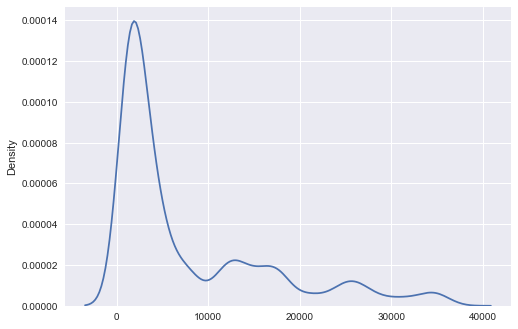

In [20]:
# display density of our data
sns.distplot(df_indices, hist=False, kde=True)

<AxesSubplot:title={'center':'DJI_Close/SP_Close/NQ_Close/RUT2K_Close/RUT3K_Close'}, xlabel='Date'>

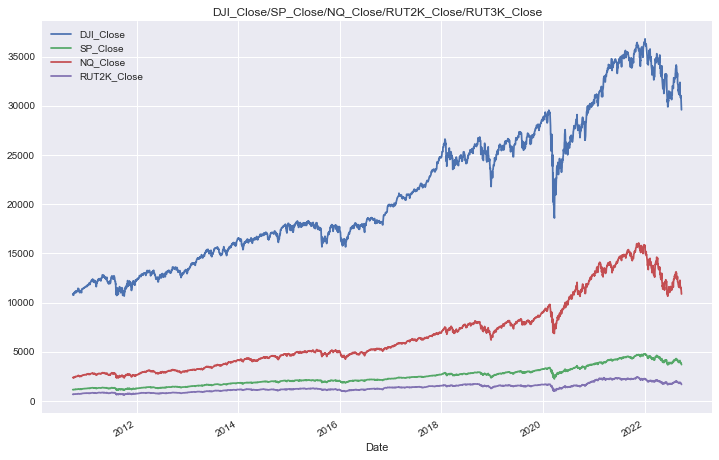

In [21]:
df_indices.plot(figsize=(12, 8), title="DJI_Close/SP_Close/NQ_Close/RUT2K_Close/RUT3K_Close")

In [22]:
# Creating Daily Return
df_indices["Return_DJI"] = df_indices["DJI_Close"].pct_change()
df_indices["Return_SP"] = df_indices["SP_Close"].pct_change()
df_indices["Return_NQ"] = df_indices["NQ_Close"].pct_change()
df_indices["Return_RUT2K"] = df_indices["RUT2K_Close"].pct_change()


In [23]:
# new data frame with pct_change
df_indices

,DJI_Close,SP_Close,NQ_Close,RUT2K_Close,Return_DJI,Return_SP,Return_NQ,Return_RUT2K
Date,,,,,,,,
2010-09-28 16:00:00,10858.14,1147.70,2379.59,675.43,NaN,NaN,NaN,NaN
2010-09-29 16:00:00,10835.28,1144.73,2376.56,677.64,-0.002105,-0.002588,-0.001273,0.003272
2010-09-30 16:00:00,10788.05,1141.20,2368.62,676.14,-0.004359,-0.003084,-0.003341,-0.002214
2010-10-01 16:00:00,10829.70,1146.24,2370.75,679.29,0.003861,0.004416,0.000899,0.004659
2010-10-04 16:00:00,10751.27,1137.03,2344.52,669.45,-0.007242,-0.008035,-0.011064,-0.014486
...,...,...,...,...,...,...,...,...
2022-09-19 16:00:00,31019.68,3899.89,11535.02,1812.84,0.006400,0.006857,0.007566,0.008147
2022-09-20 16:00:00,30706.23,3855.93,11425.05,1787.50,-0.010105,-0.011272,-0.009534,-0.013978
2022-09-21 16:00:00,30183.78,3789.93,11220.19,1762.16,-0.017014,-0.017116,-0.017931,-0.014176


In [24]:
# dropna's
df_indices.dropna(inplace=True)

<AxesSubplot:ylabel='Density'>

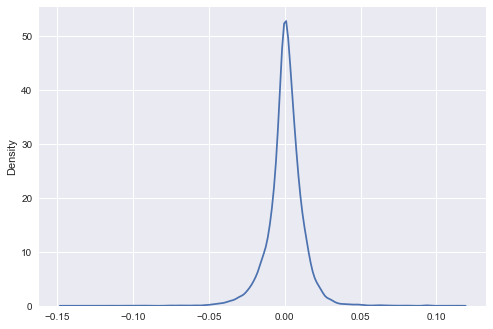

In [25]:
# display returns
sns.distplot(df_indices[['Return_DJI','Return_SP','Return_NQ','Return_RUT2K']], 
                             hist=False, kde=True)

In [26]:
# Calculating rolling std for 5-day window
df_indices["std_DJI"] = df_indices["Return_DJI"].rolling(window=5).std()
df_indices["std_SP"] = df_indices["Return_SP"].rolling(window=5).std()
df_indices["std_NQ"] = df_indices["Return_NQ"].rolling(window=5).std()
df_indices["std_RUT2K"] = df_indices["Return_RUT2K"].rolling(window=5).std()


In [27]:
# Drop na's
volatility_df.dropna(inplace=True)

In [28]:
# data frame
display(df_indices.head(2))
display(df_indices.tail(2))

,DJI_Close,SP_Close,NQ_Close,RUT2K_Close,Return_DJI,Return_SP,Return_NQ,Return_RUT2K,std_DJI,std_SP,std_NQ,std_RUT2K
Date,,,,,,,,,,,,
2010-09-29 16:00:00,10835.28,1144.73,2376.56,677.64,-0.002105,-0.002588,-0.001273,0.003272,NaN,NaN,NaN,NaN
2010-09-30 16:00:00,10788.05,1141.20,2368.62,676.14,-0.004359,-0.003084,-0.003341,-0.002214,NaN,NaN,NaN,NaN


,DJI_Close,SP_Close,NQ_Close,RUT2K_Close,Return_DJI,Return_SP,Return_NQ,Return_RUT2K,std_DJI,std_SP,std_NQ,std_RUT2K
Date,,,,,,,,,,,,
2022-09-22 16:00:00,30076.68,3757.99,11066.81,1722.31,-0.003548,-0.008428,-0.013670,-0.022614,0.008658,0.008857,0.009684,0.011552
2022-09-23 16:00:00,29590.41,3693.23,10867.93,1679.59,-0.016168,-0.017233,-0.017971,-0.024804,0.009741,0.009870,0.010586,0.013040


In [29]:
# plot volatility of indices
df_indices[["std_DJI","std_SP","std_NQ","std_RUT2K"]].iplot(title="Volatility indices",
                                                                           xTitle="Time",
                                                                           yTitle="volatility",
                                                                           theme= "solar")

# Step 2
## Check for Stationarity 
1. A Stationary in time series is one whose mean and variance does not change over time
2. perform augmentation testing Dickey-Fuller Test (ADF Test) 


In [30]:
df_indices_return = df_indices[['Return_DJI','Return_SP','Return_NQ','Return_RUT2K']]

In [31]:
df_indices_return.to_csv("df_indices_return.csv")

In [32]:
df_indices[['Return_DJI','Return_SP','Return_NQ','Return_RUT2K']].iplot(title="Returns Indices ",
                                                                           xTitle="Time",
                                                                           yTitle="volatility",
                                                                           theme= "solar")

- Ho (Null Hypothesis): The time series data is non-stationary
- H1 (alternate Hypothesis): The time series data is stationary
- p-value > 0.05: Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary.
- p-value <= 0.05: Reject the null hypothesis (H0), the data does not have a unit root and is stationary.


In [33]:
df_indices_return.reset_index("Date")

,Date,Return_DJI,Return_SP,Return_NQ,Return_RUT2K
0,2010-09-29 16:00:00,-0.002105,-0.002588,-0.001273,0.003272
1,2010-09-30 16:00:00,-0.004359,-0.003084,-0.003341,-0.002214
2,2010-10-01 16:00:00,0.003861,0.004416,0.000899,0.004659
3,2010-10-04 16:00:00,-0.007242,-0.008035,-0.011064,-0.014486
4,2010-10-05 16:00:00,0.017993,0.020861,0.023591,0.029726
...,...,...,...,...,...
3024,2022-09-19 16:00:00,0.006400,0.006857,0.007566,0.008147
3025,2022-09-20 16:00:00,-0.010105,-0.011272,-0.009534,-0.013978
3026,2022-09-21 16:00:00,-0.017014,-0.017116,-0.017931,-0.014176
3027,2022-09-22 16:00:00,-0.003548,-0.008428,-0.013670,-0.022614


In [34]:
df_indices_return.to_csv("Dickey-Fuller.csv")

In [35]:
df_update = pd.read_csv("Dickey-Fuller.csv", header=0, index_col=0)

In [36]:
values = df_update.values.reshape(-1)

In [37]:
res = adfuller(values)

In [38]:
print('Augmneted Dickey_fuller Statistic: %f' % res[0])
print('p-value: %f' % res[1])
print('critical values at different levels:')
for k, v in res[4].items():
    print('\t%s: %.3f' % (k, v))

Augmneted Dickey_fuller Statistic: -17.940401
p-value: 0.000000
critical values at different levels:
	1%: -3.431
	5%: -2.862
	10%: -2.567


# Calculate volatility for DJI

In [39]:
# Calculate daily std of returns
std_daily = df_indices_return['Return_DJI'].std()

print(f'Daily volatility: {round(std_daily,2)}%')

# Convert daily volatility to monthly volatility
std_monthly = np.sqrt(21) * std_daily

print(f'\nMonthly volatility: {round(std_monthly,5)}%')

# Convert daily volatility to annaul volatility
std_annual = np.sqrt(252) * std_daily

print(f'\nAnnual volatility: {round(std_annual,5)}%')


Daily volatility: 0.01%

Monthly volatility: 0.04945%

Annual volatility: 0.1713%


## Fit a Garch model ()  since we assumed our data is stationary
-  p = ?, q = ?

## Resample data by weakly return to get futher forcasting 

In [40]:
df_indices_return

,Return_DJI,Return_SP,Return_NQ,Return_RUT2K
Date,,,,
2010-09-29 16:00:00,-0.002105,-0.002588,-0.001273,0.003272
2010-09-30 16:00:00,-0.004359,-0.003084,-0.003341,-0.002214
2010-10-01 16:00:00,0.003861,0.004416,0.000899,0.004659
2010-10-04 16:00:00,-0.007242,-0.008035,-0.011064,-0.014486
2010-10-05 16:00:00,0.017993,0.020861,0.023591,0.029726
...,...,...,...,...
2022-09-19 16:00:00,0.006400,0.006857,0.007566,0.008147
2022-09-20 16:00:00,-0.010105,-0.011272,-0.009534,-0.013978
2022-09-21 16:00:00,-0.017014,-0.017116,-0.017931,-0.014176


In [41]:
df_Grach = df_indices_return.rolling(window=5).mean()

In [42]:
df_Grach.dropna(inplace=True)

In [43]:
df_Grach = df_Grach.resample('W').mean()

In [44]:
df_Grach.isnull().sum()

Return_DJI      0
Return_SP       0
Return_NQ       0
Return_RUT2K    0
dtype: int64

In [45]:
df_Grach.to_csv("df_Grach_W.csv")

In [46]:
df_Grach["indices_mean"] = df_Grach.mean(axis=1)

In [47]:
df_Grach

,Return_DJI,Return_SP,Return_NQ,Return_RUT2K,indices_mean
Date,,,,,
2010-10-10,0.002593,0.002831,0.001414,0.003355,0.002548
2010-10-17,0.002440,0.002847,0.004386,0.004775,0.003612
2010-10-24,0.000846,0.001019,0.002482,0.000304,0.001163
2010-10-31,0.000673,0.000984,0.003117,0.000914,0.001422
2010-11-07,0.002557,0.003422,0.003634,0.004143,0.003439
...,...,...,...,...,...
2022-08-28,-0.006202,-0.006804,-0.008888,-0.007054,-0.007237
2022-09-04,-0.007507,-0.007781,-0.009214,-0.008769,-0.008318
2022-09-11,-0.000603,0.000326,-0.000754,-0.001330,-0.000590


# Implement a basic GARCH model
1. to implement a GARCH(p,q) model, First defines basic GRACH(p,q) model, then fit model, review the model fitting summary and plot the results

In [48]:
for p in range(2):
    for q in range(2):
        if p == 0 and q == 0:
            continue
            
        print(f'Testing Order: p = {p}, q = {q}')

Testing Order: p = 0, q = 1
Testing Order: p = 1, q = 0
Testing Order: p = 1, q = 1


Optimization terminated successfully    (Exit mode 0)
            Current function value: -2641.82546534391
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
                       Zero Mean - GARCH Model Results                        
Dep. Variable:           indices_mean   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.002
Vol Model:                      GARCH   Log-Likelihood:                2641.83
Distribution:                  Normal   AIC:                          -5277.65
Method:            Maximum Likelihood   BIC:                          -5264.34
                                        No. Observations:                  625
Date:                Sat, Oct 01 2022   Df Residuals:                      625
Time:                        12:44:29   Df Model:                            0
                              Volatility Model                              
      

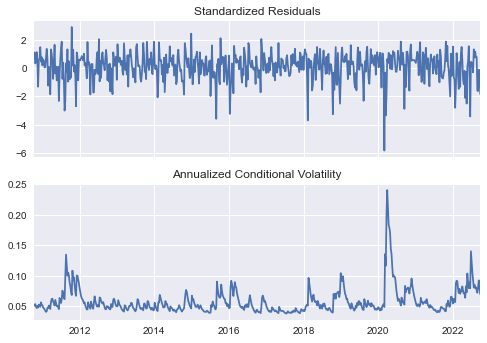

In [49]:
#GARCH model with Zero mean
model_garch_indices_mean = arch_model(df_Grach["indices_mean"], p = p, q = q,
                      mean = 'Zero', vol = 'GARCH', dist = 'normal')
# Fit the model                  freq to avoid display unnecessary value
result_indices_mean = model_garch_indices_mean.fit(update_freq = 5)


# Display model fitting summary
print(result_indices_mean.summary())


# Plot fitted results
result_indices_mean.plot(annualize='D')
plt.show()

Iteration:      5,   Func. Count:     61,   Neg. LLF: 22181918594406.676
Optimization terminated successfully    (Exit mode 0)
            Current function value: -2653.8364391201467
            Iterations: 13
            Function evaluations: 116
            Gradient evaluations: 9
                     Constant Mean - GARCH Model Results                      
Dep. Variable:           indices_mean   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                2653.84
Distribution:                  Normal   AIC:                          -5299.67
Method:            Maximum Likelihood   BIC:                          -5281.92
                                        No. Observations:                  625
Date:                Sat, Oct 01 2022   Df Residuals:                      624
Time:                        12:44:30   Df Model:                            1
     

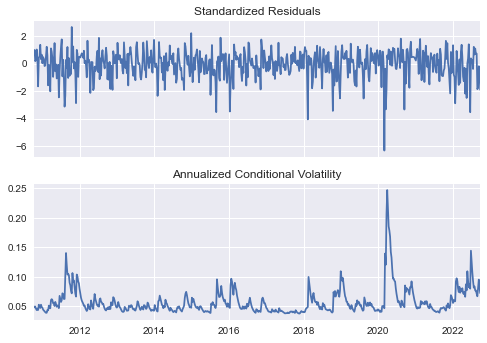

In [50]:
#GARCH model with constant mean
model_garch_indices_mean = arch_model(df_Grach['indices_mean'], p = p, q = q,
                      mean = 'constant', vol = 'GARCH', dist = 'normal')
# Fit the model                  freq to avoid display unnecessary value
result_indices_mean = model_garch_indices_mean.fit(update_freq = 5)


# Display model fitting summary
print(result_indices_mean.summary())


# Plot fitted results
result_indices_mean.plot(annualize='D')
plt.show()


# Make forecast with GARCH models

In [51]:
# horizon = how many observations we want our model to predict for each day 
# for each date, we'll get the predicted value, for the next date
pred_grach = result_indices_mean.forecast(start = "2022-09-23",horizon= 5)
# prediction value for next weeks
print(pred_grach.variance[-1:])

                 h.1      h.2       h.3       h.4       h.5
Date                                                       
2022-09-25  0.000031  0.00003  0.000028  0.000027  0.000026


<AxesSubplot:>

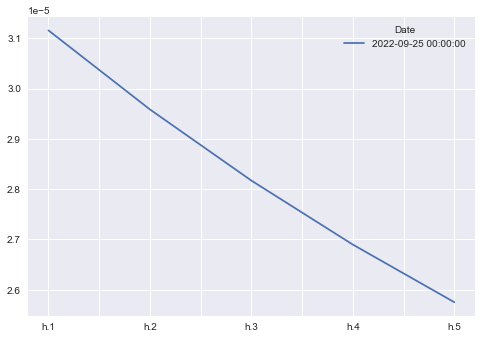

In [52]:
# plot prediction
pred_grach.variance[-1:].T.plot()

# Distribution assumptions
1. Volatility is not directly observed
2. GARCH model use residuals as volatilty shocks
3. Volatility is related to the residuals
### Residual = predicted return - mean return
  - Residual = predicted return - mean return
 
  - Standardized residual = residual / return volatility


# Plot distribution of standardized residuals

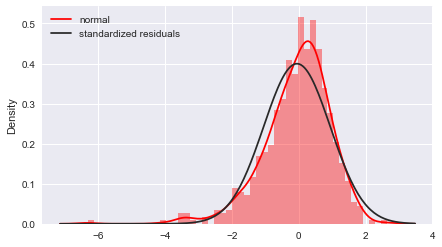

In [53]:
# residuals and volatility
model_indices_mean_resid = result_indices_mean.resid
model_indices_mean_std = result_indices_mean.conditional_volatility

# Calculate the standardized residuals
result_indices_mean_std = model_indices_mean_resid /model_indices_mean_std

# Plot the histogram of the standardized residuals
plt.figure(figsize=(7,4))
sns.distplot(result_indices_mean_std, norm_hist=True, fit=stats.norm, bins=50, color='r')
plt.legend(('normal', 'standardized residuals'))
plt.show()

In [54]:
print(f'GARCH BIC : { result_indices_mean.bic}')
print(f'GARCH AIC : { result_indices_mean.aic}')

GARCH BIC : -5281.921871641348
GARCH AIC : -5299.672878240293


# Fit a GARCH with skewed t-distribution
- We improve the GARCH model by using a skewed t-distribution

In [55]:
# Garch model skewt
model_garch_indices_mean = arch_model(df_Grach['Return_DJI'], p = 1, q = 1,
                       mean = 'constant', vol = 'GARCH', dist = 'skewt')

# fit the model
model_garch_indices_mean_result = model_garch_indices_mean.fit(disp='off')

# get estimated volatility 
vol_Grch_model = model_garch_indices_mean_result.conditional_volatility

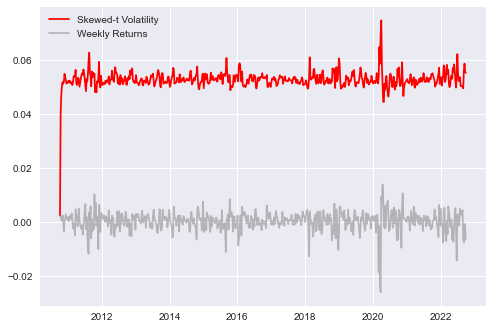

In [56]:
# Plot model fitting results
plt.plot(vol_Grch_model, color = 'red', label = 'Skewed-t Volatility')
plt.plot(df_Grach['Return_DJI'], color = 'grey', 
         label = 'Weekly Returns', alpha = 0.5)
plt.legend()
plt.show()

# LSTM Data Preparation
1. Transform the time series into supervised learning problem
2. Transform the time series data so that it is stationary
3. Transform the observations to have a specific scale

   - The LSTM model in keras assumes that your data is divided into input(X) and output(y) componemts
   
   - For a time series problem, we can achieve this by using the observation from the last time step (t-1) as the input and            the observation at the current time step (t) as the output.

In [57]:
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [58]:
stocks = ['^DJI','^IXIC','^GSPC','^RUT']
start = dt.datetime.today()-dt.timedelta(4370)
end = dt.datetime.today()
volatility = pd.DataFrame()
for ticker in stocks:
    volatility[ticker] = yf.download(ticker,start,end)['Close']

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [59]:
Lstm_volatility = pd.read_csv("Lstm_volatility.csv").rename(columns={"^DJI":"DJI_Close",
                                                   "^IXIC":"SP_Close",
                                                   "^GSPC":"NQ_Close",
                                                   "^RUT":"RUT_Close"})

In [60]:
Lstm_volatility.isnull().sum()

Unnamed: 0.2    0
Unnamed: 0.1    0
Unnamed: 0      0
Date            0
DJI_Close       0
SP_Close        0
NQ_Close        0
RUT_Close       0
dtype: int64

In [61]:
Lstm_volatility.to_csv("Lstm_volatility.csv")

In [62]:
def window_data(df, window, feature_col_number, target_col_number):
    X = []
    y = []
    
    for x in range(len(df) - window):
        # range of rows      # range of columns
        feature = df.iloc[x:(x+window), feature_col_number]
        # in this case there is no range 
        target = df.iloc[(x+window),target_col_number]
        X.append(feature)
        y.append(target)
    return np.array(X), np.array(y).reshape(-1,1)

In [63]:
# window 5 days in future 
window = 5 
feature_column = 2
target_column = 2 
X,y = window_data(Lstm_volatility,window,feature_column,target_column)

In [64]:
# train test split
split = int(0.7 * len(X))
X_train =X[:split]
X_test = X[split:]

y_train =y[:split]
y_test = y[split:]

In [65]:
# scale X 
scaler = MinMaxScaler()
scaler.fit(X)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [66]:
# scale y because it's time series
scaler.fit(y)
y_train_scaled = scaler.transform(y_train)
y_test_scaled = scaler.transform(y_test)

In [67]:
# LSTM API from keras needs to recieve features as a vertical vector, therefore we need to reshape the x
X_train_scaled = X_train_scaled.reshape(X_train_scaled.shape[0], X_train_scaled.shape[1],1)
X_test_scaled = X_test_scaled.reshape(X_test_scaled.shape[0], X_test_scaled.shape[1],1)

In [68]:
model = Sequential()
# hidden layer 1 of LSTM                                      # get  second columns 
model.add(LSTM(units= window, return_sequences=True, input_shape =(X_train_scaled.shape[1],1)   ))
# each epochs drop 20% randomly to simplify the model 
model.add(Dropout(0.2))
# hidden layer 2 of LSTM
model.add(LSTM(units= window, return_sequences=True    ))
# each epochs drop 20% randomly to simplify the model 
model.add(Dropout(0.2))
# hidden layer 3 of LSTM
model.add(LSTM(units= window, return_sequences=False    ))
# each epochs drop 20% randomly to simplify the model 
model.add(Dropout(0.2))

# output layer
model.add(Dense(1))

In [69]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 5, 5)              140       
                                                                 
 dropout (Dropout)           (None, 5, 5)              0         
                                                                 
 lstm_1 (LSTM)               (None, 5, 5)              220       
                                                                 
 dropout_1 (Dropout)         (None, 5, 5)              0         
                                                                 
 lstm_2 (LSTM)               (None, 5)                 220       
                                                                 
 dropout_2 (Dropout)         (None, 5)                 0         
                                                                 
 dense (Dense)               (None, 1)                 6

In [70]:
# time series is continues target, regression metric
model.compile(loss="categorical_crossentropy", optimizer="adam",metrics=['accuracy'])

In [71]:
model.fit(X_train_scaled, y_train_scaled, epochs = 100, shuffle=False, batch_size = 100, verbose = 1)

Epoch 1/100
22/22 [==============================] - 8s 8ms/step - loss: nan - accuracy: 4.7529e-04
Epoch 2/100
22/22 [==============================] - 0s 7ms/step - loss: nan - accuracy: 4.7529e-04
Epoch 3/100
22/22 [==============================] - 0s 7ms/step - loss: nan - accuracy: 4.7529e-04
Epoch 4/100
22/22 [==============================] - 0s 7ms/step - loss: nan - accuracy: 4.7529e-04
Epoch 5/100
22/22 [==============================] - 0s 7ms/step - loss: nan - accuracy: 4.7529e-04
Epoch 6/100
22/22 [==============================] - 0s 7ms/step - loss: nan - accuracy: 4.7529e-04
Epoch 7/100
22/22 [==============================] - 0s 7ms/step - loss: nan - accuracy: 4.7529e-04
Epoch 8/100
22/22 [==============================] - 0s 7ms/step - loss: nan - accuracy: 4.7529e-04
Epoch 9/100
22/22 [==============================] - 0s 7ms/step - loss: nan - accuracy: 4.7529e-04
Epoch 10/100
22/22 [==============================] - 0s 7ms/step - loss: nan - accuracy: 4.7529e-04

22/22 [==============================] - 0s 7ms/step - loss: nan - accuracy: 4.7529e-04
Epoch 83/100
22/22 [==============================] - 0s 7ms/step - loss: nan - accuracy: 4.7529e-04
Epoch 84/100
22/22 [==============================] - 0s 7ms/step - loss: nan - accuracy: 4.7529e-04
Epoch 85/100
22/22 [==============================] - 0s 7ms/step - loss: nan - accuracy: 4.7529e-04
Epoch 86/100
22/22 [==============================] - 0s 7ms/step - loss: nan - accuracy: 4.7529e-04
Epoch 87/100
22/22 [==============================] - 0s 7ms/step - loss: nan - accuracy: 4.7529e-04
Epoch 88/100
22/22 [==============================] - 0s 7ms/step - loss: nan - accuracy: 4.7529e-04
Epoch 89/100
22/22 [==============================] - 0s 7ms/step - loss: nan - accuracy: 4.7529e-04
Epoch 90/100
22/22 [==============================] - 0s 7ms/step - loss: nan - accuracy: 4.7529e-04
Epoch 91/100
22/22 [==============================] - 0s 7ms/step - loss: nan - accuracy: 4.7529e-04
Epo

In [72]:
model.evaluate(X_test_scaled, y_test_scaled)

29/29 [==============================] - 2s 2ms/step - loss: nan - accuracy: 0.0000e+00


[nan, 0.0]

In [73]:
y_pred_lstm = model.predict(X_test_scaled)

29/29 [==============================] - 2s 2ms/step


In [74]:
y_pred_lstm_in_prices = scaler.inverse_transform(y_pred_lstm)

In [75]:
y_true_in_prices = scaler.inverse_transform(y_test_scaled).reshape(-1,1)

In [76]:
stock_output = pd.DataFrame({
    "Real": y_true_in_prices.ravel(),
    "Predictions": y_pred_lstm_in_prices.ravel()
}
, index =Lstm_volatility.index[-len(y_true_in_prices):]
) 


In [77]:
stock_output

,Real,Predictions
2109,2109.0,NaN
2110,2110.0,NaN
2111,2111.0,NaN
2112,2112.0,NaN
2113,2113.0,NaN
...,...,...
3007,3007.0,NaN
3008,3008.0,NaN
3009,3009.0,NaN
3010,3010.0,NaN
